In [23]:
import os
import sys
import copy
import pickle

import numpy as np
import rmgpy.chemkin
import rmgpy.tools.uncertainty

import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# Load the RMG mechanism

# Load the base model and the covariance matrix
# basedir = '/work/westgroup/harris.se/autoscience/autoscience/butane/models/rmg_model'
basedir = '/home/moon/autoscience/autoscience/butane/models/rmg_model'

base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)

# covariance_file = '/work/westgroup/harris.se/autoscience/autoscience/uncertainty/butane_covariance.pickle'
covariance_file = '/home/moon/autoscience/autoscience/uncertainty/butane_covariance.pickle'
with open(covariance_file, 'rb') as handle:
    Sigma_k = pickle.load(handle)


# Load the RMG Database

In [25]:
# load the model

uncertainty = rmgpy.tools.uncertainty.Uncertainty(output_directory='rmg_uncertainty')
uncertainty.load_model(base_chemkin, dictionary)




# TODO - force the user to provide the input file used to generate the mechanism to ensure databases are really the same
# load the database
# --------------- CAUTION!!! Databases here must match the ones used to generate the mechanism
# note - this cell stalls out on Discovery
thermo_libs = [
    'BurkeH2O2',
    'primaryThermoLibrary',
    'FFCM1(-)',
    'CurranPentane',
    'Klippenstein_Glarborg2016',
    'thermo_DFT_CCSDTF12_BAC',
    'DFT_QCI_thermo',
    'CBS_QB3_1dHR',
]

kinetic_libs = [
    'FFCM1(-)',
    'CurranPentane',
    'combustion_core/version5',
    'Klippenstein_Glarborg2016',
    'BurkeH2O2inArHe',
    'BurkeH2O2inN2',
]
uncertainty.load_database(
    thermo_libraries=thermo_libs,
    kinetics_families='default',
    reaction_libraries=kinetic_libs,
    kinetics_depositories=['training'],
)


In [26]:
# Get the most sensitive list
reaction_indices = np.arange(0, len(reaction_list))
base_delay = 0.14857535
# delay_file = '/work/westgroup/harris.se/autoscience/autoscience/butane/sensitivity_analysis/base_rmg24/reaction_ignition_delay.npy'
delay_file = '/home/moon/autoscience/autoscience/uncertainty/reaction_ignition_delay.npy'

ignition_delay_diffs = np.load(delay_file)
# len(ignition_delays)
sensitivity_order = [x for _,x in sorted(zip(np.abs(ignition_delay_diffs), reaction_indices))][::-1]

In [27]:
# Get the different kinetic and thermo sources
uncertainty.extract_sources_from_model()
uncertainty.assign_parameter_uncertainties()

In [28]:
# Create a giant dictionary with all of the reaction family information in it
auto_gen_families = {}
for family_name in uncertainty.database.kinetics.families.keys():
    if family_name == 'Intra_R_Add_Endocyclic' or family_name == 'Intra_R_Add_Exocyclic':
        continue
    if uncertainty.database.kinetics.families[family_name].auto_generated and family_name not in auto_gen_families.keys():
        auto_gen_families[family_name] = uncertainty.database.kinetics.families[family_name].rules.get_entries()
        auto_gen_families[f'{family_name}_labels'] = [entry.label for entry in uncertainty.database.kinetics.families[family_name].rules.get_entries()]
        auto_gen_families[f'{family_name}_rxn_map'] = uncertainty.database.kinetics.families[family_name].get_reaction_matches(
            thermo_database=uncertainty.database.thermo,
            remove_degeneracy=True,
            get_reverse=True,
            exact_matches_only=False,
            fix_labels=True)

## The reaction sources dict has PDep, Rate Rules, Library, and Training

In [29]:
# figure out what's in here
all_keys = set()
for i in range(0, len(uncertainty.reaction_list)):
    for key in uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]].keys():
        all_keys.add(key)
print(all_keys)

{'Library', 'Training', 'Rate Rules', 'PDep'}


In [30]:
# Count the estimated reactions
estimated_reactions = []
for i in range(0, len(uncertainty.reaction_list)):
    if 'Rate Rules' in uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]].keys() or \
        'Training' in uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]].keys() or \
        'PDep' in uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]].keys():
        estimated_reactions.append(i)
#         print(i)
print(len(estimated_reactions))

1267


In [31]:
# Count the number of each important family
h_abs = []
intra_H = []
disp = []
r_add = []
estimated_reactions = []
for i in range(0, len(uncertainty.reaction_list)):
    if 'Rate Rules' in uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]].keys():
        family = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][0]
        if family == 'H_Abstraction':
            h_abs.append(i)
        elif family == 'intra_H_migration':
            intra_H.append(i)
        elif family == 'Disproportionation':
            disp.append(i)
        elif family == 'R_Addition_MultipleBond':
            r_add.append(i)
#         else:
#             print(family)
    
    if 'Training' in uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]].keys():
        family = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Training'][0]
        if family == 'H_Abstraction':
            h_abs.append(i)
        elif family == 'intra_H_migration':
            intra_H.append(i)
        elif family == 'Disproportionation':
            disp.append(i)
        elif family == 'R_Addition_MultipleBond':
            r_add.append(i)
#         else:
#             print(family)
#     if 'PDep' in uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]].keys():
#         print('pdep', i, uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['PDep'])
print('H_Abstraction:', len(h_abs))
print('intra_H_migration:', len(intra_H))
print('Disproportionation:', len(disp))
print('R_Addition_MultipleBond:', len(r_add))

H_Abstraction: 266
intra_H_migration: 4
Disproportionation: 604
R_Addition_MultipleBond: 0


In [32]:
# only look at Disproportionation

this_node = uncertainty.reaction_sources_dict[uncertainty.reaction_list[213]]['Rate Rules'][1]['node']
# print(this_node)
for entry in auto_gen_families['Disproportionation']:
    if this_node == entry.label:
        print(entry)
        print(dir(entry))
        print(entry.data)

Root_N-4R->H_4CNOS-u1_N-1R!H->O_4CNOS->O_Ext-4O-R_5R!H-u0
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'binding_energies', 'children', 'data', 'data_count', 'facet', 'get_all_descendants', 'index', 'item', 'label', 'long_desc', 'metal', 'nodal_distance', 'parent', 'rank', 'reference', 'reference_type', 'short_desc', 'site', 'surface_site_density']
ArrheniusBM(A=(41.769,'m^3/(mol*s)'), n=1.71947, w0=(595400,'J/mol'), E0=(23393.7,'J/mol'), Tmin=(300,'K'), Tmax=(1500,'K'), uncertainty=RateUncertainty(mu=-0.059443513509909215, var=0.4132725572855109, Tref=1000.0, N=5, data_mean=0.0, correlation='Root_N-4R->H_4CNOS-u1_N-1R!H->O_4CNOS->O_Ext-4O-R_5R!H-u0',), comment="""BM rule fit

In [37]:
# look through all Disproportionation Reactions in the mechanism
# Count the number of each important family

node_popularity = {}

for i in range(0, len(uncertainty.reaction_list)):
    node_name = ''
    if 'Rate Rules' in uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]].keys():
        family = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][0]
        if family == 'Disproportionation':
            node_name = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][1]['node']
#     elif 'Training' in uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]].keys():
#         family = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Training'][0]
#         if family == 'Disproportionation':
#             print('Training', i)
#             node_name = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Training'][1]['node']
    if not node_name:
        continue
    
    try:
        node_popularity[node_name] += 1
    except KeyError:
        node_popularity[node_name] = 1
# print(node_popularity)



node_names1 = []
node_popularities = []
for key in node_popularity.keys():
    node_names1.append(key)
    node_popularities.append(node_popularity[key])

# sort the lists
node_order1 = np.arange(0, len(node_popularities))
most_popular_nodes = [x for _, x in sorted(zip(node_popularities, node_order1))][::-1]


for i in range(0, len(node_popularities)):
    print(node_names[most_popular_nodes[i]][0:80],'\t', node_popularities[most_popular_nodes[i]])


Root_Ext-2R!H-R_2R!H->C_4R->C 	 77
Root_Ext-1R!H-R 	 66
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R_N-6R!H->S_4CHNS->C_N-Sp-6BrBr 	 60
Root_Ext-1R!H-R_N-4R->O 	 47
Root_Ext-2R!H-R_2R!H->C_N-4R->C 	 41
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R_N-6R!H->S_4CHNS->C_N-Sp-6BrBr 	 31
Root_Ext-2R!H-R 	 31
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R_N-6R!H->S_4CHNS->C_N-Sp-6BrBr 	 30
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R_N-6R!H->S_4CHNS->C_N-Sp-6BrBr 	 24
Root_Ext-1R!H-R_4R->O_Ext-4O-R_Sp-5R!H-1R!H_Ext-5R!H-R 	 22
Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCNNNSSS 	 20
Root_N-4R->H_4CNOS-u1_N-1R!H->O_4CNOS->O_Ext-4O-R_5R!H-u0 	 19
Root_Ext-1R!H-R_4R->O_Ext-4O-R_Sp-5R!H-1R!H 	 14
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H 	 12
Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCNNNSSS_N-2R! 	 12
Root_Ext-1R!H-R_4R->O_Sp-5R!H-1R!H 	 11
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R_N-6R!H->S_4CHNS->C_N-Sp-6BrBr 	 9
Root_N

In [34]:
# don't just count the nodes to get popularity. Use the sensitivity of each reaction

# start by loading sensitivity of reactions
rxn_sensitivity_file = '/home/moon/autoscience/autoscience/butane/sensitivity_analysis/base_rmg24/reaction_ignition_delay_plain.npy'
base_delay = 0.14857535
ignition_delay = np.load(rxn_sensitivity_file)
sensitivities = np.abs(ignition_delay - base_delay) / base_delay

## print nodes in order of sensitivity

In [35]:
# look through all Disproportionation Reactions in the mechanism
# Count the number of each important family

node_scores = {}

for i in range(0, len(uncertainty.reaction_list)):
    node_name = ''
    if 'Rate Rules' in uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]].keys():
        family = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][0]
        if family == 'Disproportionation':
            node_name = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][1]['node']

            try:
                node_scores[node_name] += sensitivities[i]
            except KeyError:
                node_scores[node_name] = sensitivities[i]

node_names = []
node_sensitivities = []
for key in node_scores.keys():
#     print(key[0:50],'\t', node_scores[key])
    node_names.append(key)
    node_sensitivities.append(node_scores[key])

# sort the lists
node_order = np.arange(0, len(node_sensitivities))
most_sensitive_node = [x for _, x in sorted(zip(node_sensitivities, node_order))][::-1]



for i in range(0, len(node_sensitivities)):
    print(node_names[most_sensitive_node[i]][0:80],'\t', node_sensitivities[most_sensitive_node[i]])

Root_Ext-1R!H-R 	 0.00015648966491144296
Root_Ext-2R!H-R_2R!H->C_N-4R->C 	 0.0001134313361324096
Root_N-4R->H_4CNOS-u1_N-1R!H->O_4CNOS->O_Ext-4O-R_5R!H-u0 	 8.124181614490927e-05
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R_N-6R!H->S_4CHNS->C_N-Sp-6BrBr 	 9.088279030028202e-06
Root_Ext-1R!H-R_4R->O_Ext-4O-R_Sp-5R!H-1R!H 	 7.244567322025631e-06
Root_Ext-2R!H-R_2R!H->C_4R->C 	 6.767533886636907e-06
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R_N-6R!H->S_4CHNS->C_N-Sp-6BrBr 	 6.3395347510936755e-06
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_4CHNS->C_4C-u1 	 3.7099963553449085e-06
Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCNNNSSS_N-2R! 	 3.659578544519467e-06
Root_Ext-1R!H-R_N-4R->O 	 2.830330571088675e-06
Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCNNNSSS 	 2.3027893054837497e-06
Root_Ext-2R!H-R 	 2.0976388686698824e-06
Root_Ext-1R!H-R_4R->O_Sp-5R!H-1R!H 	 1.836325051634075e-06
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R_N-6R!

In [36]:
training_rxns = auto_gen_families['Disproportionation_rxn_map']['Root_Ext-1R!H-R']

for rxn in training_rxns:
    print(rxn)


C3H7-2 + O2 <=> HO2 + C3H6-2
CH2 + C3H7-2 <=> CH3 + C3H6-2
C2H3S + C3H7-2 <=> C2H4S + C3H6-2
H + C3H7-2 <=> H2 + C3H6-2
C4H7 + C2H5S <=> C4H8 + C2H4S-2
CH3_r1 + C3H7-2 <=> CH4 + C3H6-2
C3H7-2 + C2H5-2 <=> C2H6 + C3H6-2
C5H7 + C2H5S <=> C5H8 + C2H4S-2
C3H5 + C3H7-2 <=> C3H6 + C3H6-2
C2H3S + C4H9-2 <=> C2H4S + C4H8-2
CH3O-2 + C3H7-2 <=> CH4O + C3H6-2
C4H9-2 + CH3S <=> CH4S + C4H8-2
C3H7-2 + C3H7 <=> C3H8 + C3H6-2
C3H7-2 + C4H9 <=> C4H10 + C3H6-2
C2H3-2 + C3H7-2 <=> C2H4-2 + C3H6-2
HS2 + C5H9 <=> H2S2 + C5H8-2
C2H + C3H7-2 <=> C2H2 + C3H6-2
HO + C3H7-2 <=> H2O + C3H6-2
C4H9-2 + O2 <=> HO2 + C4H8-2
C2H + C4H9-2 <=> C2H2 + C4H8-2
H + C4H9-2 <=> H2 + C4H8-2
CH3_r1 + C4H9-2 <=> CH4 + C4H8-2
C4H9-2 + C2H5-2 <=> C2H6 + C4H8-2
CH3O-2 + C4H9-2 <=> CH4O + C4H8-2
C3H5 + C4H9-2 <=> C3H6 + C4H8-2
C4H9-2 + C3H7 <=> C3H8 + C4H8-2
C4H9-2 + C4H9 <=> C4H10 + C4H8-2
C2H3-2 + C4H9-2 <=> C2H4-2 + C4H8-2
HO + C4H9-2 <=> H2O + C4H8-2
C3H5-2 + O2 <=> HO2 + C3H4
CH3_r1 + C3H5-2 <=> CH4 + C3H4
C3H5-2 + C2H5-2 <=>

419 HO2(16) + CH2CHO(21) <=> H2O2(17) + CH2CO(24)


595 O(5) + CH2CHO(21) <=> OH(15) + CH2CO(24)


629 HO2(16) + C2H4O(703) <=> H2O2(17) + CH2CHO(21)


630 OH(15) + C2H4O(703) <=> H2O(8) + CH2CHO(21)


693 O2(2) + C2H4O(703) <=> HO2(16) + CH2CHO(21)


859 C2H4O(703) + S(225) <=> CH2CHO(21) + S(787)


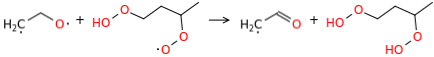

860 C2H4O(703) + S(229) <=> CH2CHO(21) + S(787)


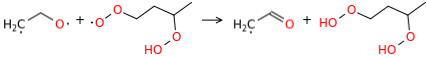

869 CH2CHO(21) + S(225) <=> CH2CO(24) + S(787)


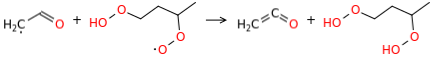

870 CH2CHO(21) + S(229) <=> CH2CO(24) + S(787)


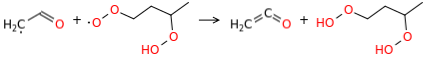

915 O2(2) + S(777) <=> HO2(16) + S(252)


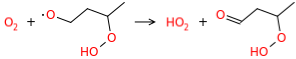

916 OH(15) + S(777) <=> H2O(8) + S(252)


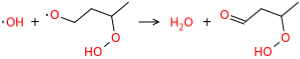

918 HO2(16) + S(777) <=> H2O2(17) + S(252)


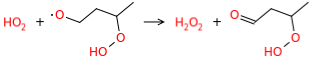

928 O(5) + S(777) <=> OH(15) + S(252)


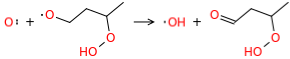

932 S(777) + S(225) <=> S(252) + S(787)


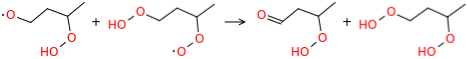

933 S(777) + S(229) <=> S(252) + S(787)


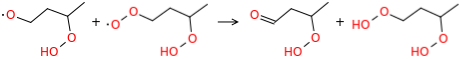

963 HO2(16) + C2H5O(49) <=> H2O2(17) + CH3CHO(35)


977 O(5) + C2H5O(49) <=> OH(15) + CH3CHO(35)


979 C2H5O(49) + S(225) <=> CH3CHO(35) + S(787)


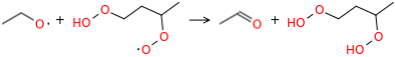

980 C2H5O(49) + S(229) <=> CH3CHO(35) + S(787)


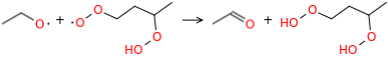

1103 CH3O2(45) + CH2CHO(21) <=> CH3O2H(46) + CH2CO(24)


1108 CH3O2(45) + C2H4O(703) <=> CH3O2H(46) + CH2CHO(21)


1117 CH3O2(45) + S(777) <=> CH3O2H(46) + S(252)


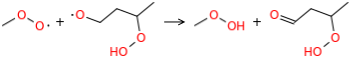

1118 CH3O2(45) + C2H5O(49) <=> CH3O2H(46) + CH3CHO(35)


1212 O(5) + C3H5O(129) <=> OH(15) + C3H4O(74)


1213 HO2(16) + C3H5O(129) <=> H2O2(17) + C3H4O(74)


1218 OH(15) + C3H5O(129) <=> H2O(8) + C3H4O(74)


1232 CH3O2(45) + C3H5O(129) <=> CH3O2H(46) + C3H4O(74)


1241 C3H5O(129) + S(225) <=> C3H4O(74) + S(787)


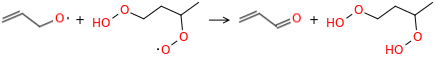

1242 C3H5O(129) + S(229) <=> C3H4O(74) + S(787)


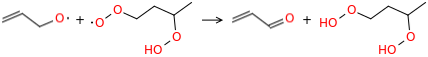

1326 CH2CHO(21) + C3H5O3(72) <=> CH2CO(24) + C3H6O3(73)


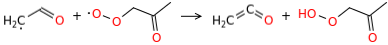

1354 C3H5O3(72) + S(777) <=> C3H6O3(73) + S(252)


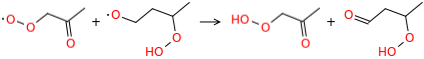

1357 C2H5O(49) + C3H5O3(72) <=> CH3CHO(35) + C3H6O3(73)


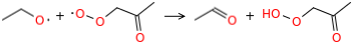

1428 C3H5O(129) + C3H5O3(72) <=> C3H4O(74) + C3H6O3(73)


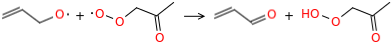

1433 C2H4O(703) + C3H5O3(72) <=> CH2CHO(21) + C3H6O3(73)


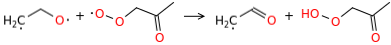

1520 CH3O(31) + CH2CHO(21) <=> CH3OH(30) + CH2CO(24)


1528 CH3O(31) + S(777) <=> CH3OH(30) + S(252)


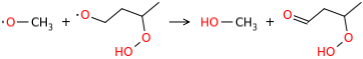

1529 CH3O(31) + C2H5O(49) <=> CH3OH(30) + CH3CHO(35)


1532 CH3O(31) + C3H5O(129) <=> CH3OH(30) + C3H4O(74)


1545 OH(15) + OCHO(38) <=> H2O(8) + CO2(7)


1547 HO2(16) + OCHO(38) <=> H2O2(17) + CO2(7)


1563 OCHO(38) + S(225) <=> CO2(7) + S(787)


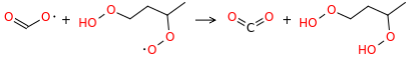

1564 OCHO(38) + S(229) <=> CO2(7) + S(787)


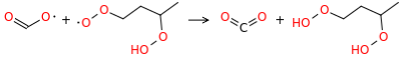

1567 OCHO(38) + CH3O2(45) <=> CO2(7) + CH3O2H(46)


1572 OCHO(38) + C3H5O3(72) <=> CO2(7) + C3H6O3(73)


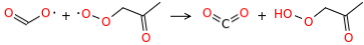

1578 OCHO(38) + C2H4O(703) <=> HOCHO(40) + CH2CHO(21)


1581 OCHO(38) + CH2CHO(21) <=> HOCHO(40) + CH2CO(24)


1584 OCHO(38) + OCHO(38) <=> CO2(7) + HOCHO(40)


1593 OCHO(38) + S(777) <=> HOCHO(40) + S(252)


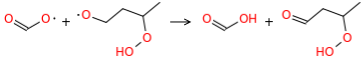

1595 OCHO(38) + C2H5O(49) <=> HOCHO(40) + CH3CHO(35)


1602 OCHO(38) + C3H5O(129) <=> HOCHO(40) + C3H4O(74)


1613 O(5) + OCHO(38) <=> OH(15) + CO2(7)


1619 OCHO(38) + CH3O(31) <=> CO2(7) + CH3OH(30)


1629 CH3O(31) + C2H4O(703) <=> CH3OH(30) + CH2CHO(21)


1658 CH2CHO(21) + C2H5O2(47) <=> CH2CO(24) + C2H6O2(48)


1680 C2H4O(703) + C2H5O2(47) <=> CH2CHO(21) + C2H6O2(48)


1684 OCHO(38) + C2H5O2(47) <=> CO2(7) + C2H6O2(48)


1691 C2H5O2(47) + S(777) <=> C2H6O2(48) + S(252)


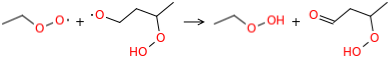

1692 C2H5O(49) + C2H5O2(47) <=> CH3CHO(35) + C2H6O2(48)


1695 C2H5O2(47) + C3H5O(129) <=> C2H6O2(48) + C3H4O(74)


1721 CH2CHO(21) + S(186) <=> CH2CO(24) + S(187)


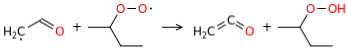

1754 C2H4O(703) + S(186) <=> CH2CHO(21) + S(187)


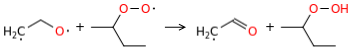

1763 OCHO(38) + S(186) <=> CO2(7) + S(187)


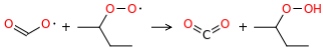

1781 S(186) + S(777) <=> S(252) + S(187)


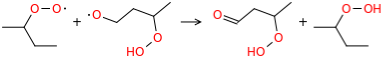

1785 C2H5O(49) + S(186) <=> CH3CHO(35) + S(187)


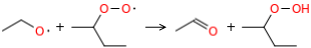

1793 C3H5O(129) + S(186) <=> C3H4O(74) + S(187)


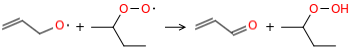

1814 O2(2) + S(5425) <=> HO2(16) + S(5951)


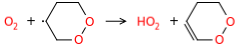

In [45]:
# list all of the reactions that fall under the important node:
# Root_Ext-2R!H-R_2R!H->C_4R->C 
node_reactions = []
reaction_sensitivities = []
ref_node = 'Root_Ext-1R!H-R'
for i in range(0, len(uncertainty.reaction_list)):
    node_name = ''
    if 'Rate Rules' in uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]].keys():
        family = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][0]
        if family == 'Disproportionation':
            node_name = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][1]['node']
            if node_name == ref_node:
                print(i, uncertainty.reaction_list[i])
                display(uncertainty.reaction_list[i])
                node_reactions.append(i)
                reaction_sensitivities.append(np.abs(ignition_delay_diffs[i]))


In [21]:
ignition_delay_diffs[674]

4.8149042808365294e-09

In [40]:
sensitive_node_reactions = [x for _, x in sorted(zip(reaction_sensitivities, node_reactions))][::-1]

In [44]:
for i in range(0, 100):
    print(sensitive_node_reactions[i], uncertainty.reaction_list[sensitive_node_reactions[i]], ignition_delay_diffs[sensitive_node_reactions[i]])

794 CH3(18) + C4H7(190) <=> CH4(10) + C4H6(194) 3.2390228513201613e-07
795 C4H7(190) + C4H7(190) <=> C4H6(194) + C4H8(189) 2.949890284820178e-07
579 C3H5-A(94) + SC4H9(183) <=> C3H6(12) + C4H8(188) 2.2026741069991473e-08
411 CH3(18) + SC4H9(183) <=> CH4(10) + C4H8(188) 1.8422742664725433e-08
802 CH2CHO(21) + C4H7(190) <=> CH3CHO(35) + C4H6(194) 1.5613332737807184e-08
798 C4H7(190) + SC4H9(183) <=> C4H6(194) + butane(1) 1.3837805623584387e-08
728 C4H7(190) + SC4H9(183) <=> C4H8(188) + C4H8(189) 1.3158770600929515e-08
731 C4H7(190) + SC4H9(183) <=> C4H8(188) + C4H8(188) 1.2648182889929416e-08
1625 CH3(18) + C4H8(748) <=> CH4(10) + C4H7(191) 5.2546461071223405e-09
1065 C2H3(22) + C4H8(748) <=> C2H4(11) + C4H7(191) 5.214082332560821e-09
1410 C4H6(2534) + SC4H9(183) <=> C4H7(191) + C4H8(188) 5.075945219701339e-09
445 CH3CO(20) + SC4H9(183) <=> CH3CHO(35) + C4H8(188) 5.014374887535311e-09
669 IC3H7(93) + C4H8(748) <=> C3H6(12) + SC4H9(183) 4.966184380394978e-09
1191 C4H7(192) + C4H7(190) <=>

IndexError: list index out of range

In [ ]:
# try to rank training reactions

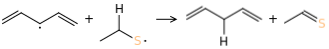

In [66]:
training_rxns[7]

In [53]:
rxn.kinetics

Arrhenius(A=(675,'cm^3/(mol*s)'), n=2.7, Ea=(-4.403,'kcal/mol'), T0=(1,'K'))

In [29]:
# plt.hist(sensitivities, bins=200)
# plt.xscale('log')

In [68]:
for key in node_popularity:
    print(key[:50],'\t', node_popularity[key])

Root_N-4R->H_4CNOS-u1_N-1R!H->O_4CNOS->O_Ext-4O-R_ 	 19
Root_Ext-2R!H-R 	 31
Root_Ext-1R!H-R_N-4R->O 	 47
Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CN 	 8
Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CN 	 12
Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CN 	 3
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R 	 24
Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CN 	 7
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R 	 31
Root_Ext-2R!H-R_2R!H->C_4R->C 	 77
Root_Ext-1R!H-R_4R->O_Ext-4O-R_Sp-5R!H-1R!H 	 14
Root_Ext-2R!H-R_2R!H->C_N-4R->C 	 41
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_4CHNS->C_N- 	 3
Root_Ext-1R!H-R_4R->O_Sp-5R!H-1R!H 	 11
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R 	 7
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_4CHNS->C_4C 	 3
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R 	 9
Root_Ext-1R!H-R 	 66
Root_Ext-1R!H-R_4R->O_Ext-4O-R_Sp-5R!H-1R!H_Ext-5R 	 22
Root_Ext-1R!H-R_4R->O 	 7
Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_N-4CHNS->C 	 4
Root_Ext-1R!H-R_N-4R->O

In [138]:
uncertainty.reaction_sources_dict[uncertainty.reaction_list[215]]['Training']

['Disproportionation',
 <Entry index=3 label="CH2 + C2H5 <=> CH3 + C2H4">,
 False]

In [133]:
auto_gen_families['Disproportionation_rxn_map'][this_node][4]

In [104]:
uncertainty.reaction_sources_dict[uncertainty.reaction_list[213]]['Rate Rules'][1]

{'template': '',
 'degeneracy': 3.0,
 'exact': False,
 'rules': '',
 'training': '',
 'node': 'Root_N-4R->H_4CNOS-u1_N-1R!H->O_4CNOS->O_Ext-4O-R_5R!H-u0',
 'node_std_dev': 1.4381251318640216,
 'node_n_train': 5}

In [72]:
# get the group info
uncertainty.database.kinetics.families['intra_H_migration'].groups.entries["O_rad_out"]

<Entry index=209 label="O_rad_out">

In [85]:
uncertainty.reaction_sources_dict[uncertainty.reaction_list[324]]['Rate Rules'][0]

'intra_H_migration'

In [79]:
# get the training reaction info
uncertainty.reaction_sources_dict[uncertainty.reaction_list[324]]['Rate Rules'][1]['training'][0][1].label




'C7H15O2 <=> C7H15O2-2'

In [83]:
uncertainty.database.kinetics.families['intra_H_migration'].get_reaction_matches()

AttributeError: 'LogicOr' object has no attribute 'merge_groups'

In [81]:
dir(uncertainty.database.kinetics.families['intra_H_migration'])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_absorb_process',
 '_create_reaction',
 '_generate_product_structures',
 '_generate_reactions',
 '_hash_labels',
 '_load_tree',
 '_match_reactant_to_template',
 '_select_best_kinetics',
 '_split_reactions',
 'add_atom_labels_for_reaction',
 'add_entry',
 'add_reverse_attribute',
 'add_rules_from_training',
 'ancestors',
 'apply_recipe',
 'are_siblings',
 'auto_generated',
 'boundary_atoms',
 'calculate_degeneracy',
 'check_tree',
 'clean_tree',
 'clean_tree_groups',
 'clean_tree_rules',
 'compute_sensitivities',
 'cross_validate',
 'cross_validate_old',
 'depositories',
 'descend_tree',
 'descendants',
 'distribute_tree_

In [73]:
#dir(uncertainty.database.kinetics.families['intra_H_migration'])

In [44]:
uncertainty.reaction_sources_dict[uncertainty.reaction_list[324]]

{'Rate Rules': ['intra_H_migration',
  {'template': [<Entry index=203 label="R7H_OOCs4">,
    <Entry index=209 label="O_rad_out">,
    <Entry index=258 label="O_H_out">],
   'degeneracy': 1,
   'exact': False,
   'rules': [],
   'training': [(<Entry index=1298 label="R7H_OOCCCC(Cs/Cs);O_rad_out;Cs_H_out_Cs2">,
     <Entry index=268 label="C7H15O2 <=> C7H15O2-2">,
     0.19999999999999998),
    (<Entry index=1312 label="R7H_OOCCCC(Cs/Cs);O_rad_out;Cs_H_out_NDMustO">,
     <Entry index=282 label="C6H13O3 <=> C6H13O3-2">,
     0.19999999999999998),
    (<Entry index=1297 label="R7H_OOCCCC(Cs/Cs);O_rad_out;Cs_H_out_H/NonDeC">,
     <Entry index=267 label="C6H13O2-5 <=> C6H13O2-6">,
     0.36666666666666664),
    (<Entry index=1334 label="R7H_OOCs4;O_rad_out;Cs_H_out_OOH/H">,
     <Entry index=304 label="C5H11O4-7 <=> C5H11O4-8">,
     0.1),
    (<Entry index=1296 label="R7H_OOCs4;O_rad_out;Cs_H_out_2H">,
     <Entry index=266 label="C5H11O2-17 <=> C5H11O2-18">,
     0.1),
    (<Entry index

In [43]:
uncertainty.reaction_sources_dict[uncertainty.reaction_list[324]"R7H_OOCCCC(Cs/Cs);O_rad_out;Cs_H_out_Cs2"]]

TypeError: list indices must be integers or slices, not str

In [10]:
dir(uncertainty)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'all_kinetic_sources',
 'all_thermo_sources',
 'assign_parameter_uncertainties',
 'compile_all_sources',
 'database',
 'extra_species',
 'extract_sources_from_model',
 'get_uncertainty_covariance_matrix',
 'kinetic_input_uncertainties',
 'load_database',
 'load_model',
 'local_analysis',
 'output_directory',
 'reaction_list',
 'reaction_sources_dict',
 'retrieve_saturated_species_from_list',
 'sensitivity_analysis',
 'species_list',
 'species_sources_dict',
 'thermo_input_uncertainties']